# Data Prep

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [2]:
# import data
pwd = os.getcwd()
filepath = os.path.join(pwd, "housing.csv")
housing_data = pd.read_csv(filepath)

In [3]:
# group income into categories
housing_data['income_cat'] = pd.cut(x=housing_data['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels= [1, 2, 3, 4, 5])


In [4]:
# statified split based on the income categories 
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing_data, housing_data["income_cat"]):
    strat_train_set = housing_data.loc[train_index]
    strat_test_set = housing_data.loc[test_index]

In [5]:
# drop now unneccessary income_cat cols
strat_train_set.drop("income_cat", axis="columns", inplace=True)
strat_test_set.drop("income_cat", axis="columns", inplace=True)

In [19]:
# split data into input features and target output
#X = strat_train_set.drop("median_house_value", axis=1)
#y = strat_train_set["median_house_value"].copy()


In [6]:
# feature engineering function

def feature_engineering(data):
        data["bedrooms_per_household"] = data["total_bedrooms"] / data["households"]
        data["population_per_household"] = data["population"] / data["households"]
        data["rooms_per_household"] = data["total_rooms"] / data["households"]
        return data

In [7]:
# data transformation function

def data_transformations(data):

    if "median_house_value" in data.columns:
        labels = data["median_house_value"]
        data = data.drop("median_house_value", axis=1)

    else:
        labels = None

    # feature engineering
    feature_engineered_data = feature_engineering(data)
    features = list(feature_engineered_data.columns)

    # impute missing values
    imputer = SimpleImputer(strategy="median")
    data_num = feature_engineered_data.select_dtypes(include=[np.number])
    data_imputed = imputer.fit_transform(data_num)
    
    # encode categorical variables
    data_cat = feature_engineered_data.select_dtypes(exclude=[np.number])
    cat_encoder = OneHotEncoder(sparse=False)
    data_cat_1hot = cat_encoder.fit_transform(data_cat)

    features = features + cat_encoder.categories_[0].tolist()
    features.remove("ocean_proximity") # We're encoding this variable, so we don't need it in our list anymore

    # scaling
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_imputed)

    # concatenating data 
    output = np.hstack([data_scaled, data_cat_1hot])

    return output, labels, features

In [8]:
# applying transformation to train and test sets
X_train, y_train, features = data_transformations(strat_train_set)

X_test, y_test, features = data_transformations(strat_test_set)

# Model Testing

## Linear Regression

In [16]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression() # Create Linear Regression Object
lin_reg.fit(X_train, y_train)

LinearRegression()

In [33]:
from sklearn.model_selection import cross_val_score

lin_reg_scores = cross_val_score(lin_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
lin_reg_rmse = np.mean(np.sqrt(np.abs(lin_reg_scores)))
lin_reg_rmse

69199.7651808991

## Decision Tree Regression

In [10]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [30]:
tree_reg_scores = cross_val_score(tree_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
tree_reg_rmse = np.mean(np.sqrt(np.abs(tree_reg_scores)))
tree_reg_rmse

71806.9508574791

## Random Forest Regression

In [36]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [37]:
forest_reg_scores = cross_val_score(forest_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
forest_reg_rmse = np.mean(np.sqrt(np.abs(forest_reg_scores)))
forest_reg_rmse

50877.12923961453

## Ridge Regression

In [38]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(random_state=42)
ridge_reg.fit(X_train, y_train)

Ridge(random_state=42)

In [39]:
ridge_reg_scores = cross_val_score(ridge_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
ridge_reg_rmse = np.mean(np.sqrt(np.abs(ridge_reg_scores)))
ridge_reg_rmse

69198.56333635302

##  ElasticNet Regression

In [40]:
from sklearn.linear_model import ElasticNet

elastic_reg = ElasticNet(random_state=42)
xgbr.fit(X_train, y_train)

ElasticNet(random_state=42)

In [41]:
elastic_reg_scores = cross_val_score(elastic_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
elastic_reg_rmse = np.mean(np.sqrt(np.abs(elastic_reg_scores)))
elastic_reg_rmse

78626.13573264112

## XGBoost

In [43]:
import xgboost as xgb

xgbr = xgb.XGBRegressor(objective='reg:squarederror')
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [44]:
xgbr_scores = cross_val_score(xgbr, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
xgbr_rmse = np.mean(np.sqrt(np.abs(xgbr_scores)))
xgbr_rmse

47268.16519487495

# Hyperparameter Tuning

So far, the XGBoost Regressor and Randon Forests Regression performed the best. Now I will try to tune some of the hyperparameter for these to see if we can get the RMSE score even lower.

NOTE: I will be using RandomizedSerachCV instead of GridSearchCV to save time. If I had more time, I would try randomised method first and then grid search to further hone down the best params.

### Random Forests Regression Tuning

In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV

In [46]:
params_rf = {
    'n_estimators': randint(low=1, high=200), # No of trees
    'max_depth': randint(low=1, high=15), # maximum depth to explore
    'min_samples_split':[5], # minimum samples required for split
    'min_samples_leaf':[5], # minimum samples required at leaf
    'max_features': ['auto'] # number of features for the best split
}

rnd_search_rf = RandomizedSearchCV(estimator = forest_reg, # Regressor we want to use
                       param_distributions = params_rf, # Hyperparameter space
                       scoring ='neg_mean_squared_error', # Performance metric
                       cv = 5, # of folds/splits
                       n_iter=10, # number of iterations to try in random space
                       random_state=42)

# fit the model
rnd_search_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022810237280>,
                                        'max_features': ['auto'],
                                        'min_samples_leaf': [5],
                                        'min_samples_split': [5],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002281022C340>},
                   random_state=42, scoring='neg_mean_squared_error')

In [47]:
cvres = rnd_search_rf.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.mean(np.sqrt(np.abs(mean_score))), params)

57944.67954075505 {'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 180}
52533.45492466211 {'max_depth': 13, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 15}
52505.51853301992 {'max_depth': 11, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 72}
52272.57161714732 {'max_depth': 13, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 21}
57922.34784751652 {'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 122}
72684.98213861941 {'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 75}
52462.46120823257 {'max_depth': 11, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 88}
64106.837733946406 {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_es

In [49]:
print('Best Random Forests model: {}'.format(rnd_search_rf.best_estimator_))
print()
print('CV Score for best Random Forests model: {:.2f}'.format(np.mean(np.sqrt(np.abs(rnd_search_rf.best_score_)))))

Best Random Forests model: RandomForestRegressor(max_depth=13, min_samples_leaf=5, min_samples_split=5,
                      n_estimators=21, random_state=42)

CV Score for best Random Forests model: 52272.57


None of the parameters tested performed better than the default.

### XGBoost Regression Tuning

In [57]:
params_xgb = {
    'n_estimators': range(50, 800, 50),
    'max_depth': [3,6,10],
    'learning_rate': [0.01, 0.05, 0.1],
    'colsample_bytree': [0.3, 0.7]
}

rnd_search_xgb = RandomizedSearchCV(estimator = xgbr, # Regressor we want to use
                       param_distributions = params_xgb, # Hyperparameter space
                       scoring ='neg_mean_squared_error', # Performance metric
                       cv = 5, # of folds/splits
                       n_iter=10, # number of iterations to try in random space
                       random_state=42)

# fit the model
rnd_search_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          enable_categorical=False, gamma=0,
                                          gpu_id=-1, importance_type=None,
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=6,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints='()',
                                          n_estimato...
                                          num_parallel_tree=1, predictor='auto',
                                          random_state=0, reg_alpha

In [58]:
cvres = rnd_search_xgb.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.mean(np.sqrt(np.abs(mean_score))), params)

157639.04786698095 {'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.3}
46821.8127447266 {'n_estimators': 600, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.3}
48251.22322200562 {'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.3}
48854.22853980179 {'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.3}
49119.85487811072 {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
85469.78524179592 {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
45253.55202422867 {'n_estimators': 750, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
73532.21053017468 {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.3}
49566.60009951567 {'n_estimators': 450, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
45519.62686676447 {'n_estimators': 400, 'max_depth': 6, 'learning

In [59]:
print('Best XGBoost model: {}'.format(rnd_search_xgb.best_estimator_))
print()
print('CV Score for best XGBoost model: {:.2f}'.format(np.mean(np.sqrt(np.abs(rnd_search_xgb.best_score_)))))

Best XGBoost model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=750, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

CV Score for best XGBoost model: 45253.55


Slightly better than the default which was 47268.16

In [62]:
xgbr_best_model = rnd_search_xgb.best_estimator_

## Ensemble

Now I will try and combine the best models together to see if the score can be improved

In [60]:
from sklearn.ensemble import VotingRegressor

ereg = VotingRegressor(estimators = [('xg', xgbr_best_model), ('rf', forest_reg)])
ereg = ereg.fit(X_train, y_train)

In [61]:
ereg_scores = cross_val_score(ereg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
ereg_rmse_scores = np.sqrt(-ereg_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(ereg_rmse_scores)

Scores: [47884.61532063 45873.76410124 42816.98974436 47785.09171197
 44565.30756447 46306.82954351 48663.25906122 46272.83642663
 44709.32626365 50821.18231083]
Mean: 46569.92020485158
Standard deviation: 2187.8583039518526


Ensemble method didn't really improve the mean score, so will stick to XGBoost for the final model

# Testing & Saving Model

In [67]:
final_model = xgbr_best_model

final_predictions = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_rmse

63612.0475878584

The difference in score shows that the model may have overfitted the training data. Further work will need to be done to tweak the model.

In [68]:
# save the model

import pickle
pickle.dump(final_model, open('house_model_xgb.pkl', 'wb'))

## Feature Importance

Lastly, will try and see which features contributed most to the predictions in this model

In [69]:
feature_importances = xgbr_best_model.feature_importances_
feature_importances

array([0.0244663 , 0.02751533, 0.02024316, 0.00713295, 0.0067402 ,
       0.00598617, 0.0088258 , 0.13672252, 0.00707734, 0.04129819,
       0.03253761, 0.04216232, 0.56493026, 0.        , 0.01841372,
       0.05594809], dtype=float32)

In [70]:
feature_importance_list = list(zip(features, feature_importances.tolist()))
feature_importance_list

[('longitude', 0.02446630224585533),
 ('latitude', 0.027515333145856857),
 ('housing_median_age', 0.02024316042661667),
 ('total_rooms', 0.0071329474449157715),
 ('total_bedrooms', 0.006740199867635965),
 ('population', 0.005986172705888748),
 ('households', 0.008825800381600857),
 ('median_income', 0.13672251999378204),
 ('bedrooms_per_household', 0.007077337708324194),
 ('population_per_household', 0.041298191994428635),
 ('rooms_per_household', 0.032537609338760376),
 ('<1H OCEAN', 0.042162321507930756),
 ('INLAND', 0.564930260181427),
 ('ISLAND', 0.0),
 ('NEAR BAY', 0.018413720652461052),
 ('NEAR OCEAN', 0.05594809353351593)]

<BarContainer object of 16 artists>

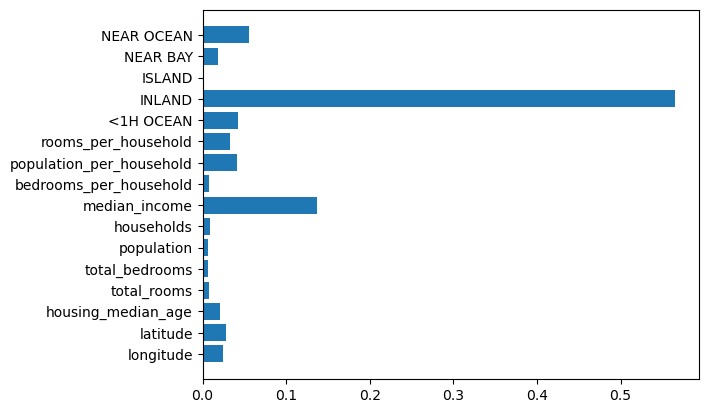

In [71]:
import matplotlib.pyplot as plt
plt.barh(y=features, width=feature_importances.tolist())